<a href="https://colab.research.google.com/github/TheDandyCodes/Deep-Learning/blob/main/Unit_2/RBM/RBM_DBN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RBMs for feature extraction and for weight initialization in a Deep Belief Network

## Clasificación de dígitos escritos a mano

MNIST https://en.wikipedia.org/wiki/MNIST_database

Adaptado de https://github.com/kaushiksk/RBM_DBN

In [1]:
# import the necessary packages
# Cambio a tensorflow 2.x
# En lugar de from keras import, from tensorflow.keras import
# ciertos subpaquetes del antiguo keras desaparacen o cambian de nombre
# ver lista siguiente

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
from sklearn.metrics import classification_report

# from keras.models import Sequential
from tensorflow.keras.models import Sequential
# from keras.layers import Dense
from tensorflow.keras.layers import Dense

In [4]:
# Load saved mnist data
# These are readily available and can be downloaded

# from keras.datasets import mnist
from tensorflow.keras.datasets import mnist

(trainx, trainy), (testx, testy) = mnist.load_data()

# reducimos el número de datos por velocidad
# si se tiene GPU o tiempo suficiente usar los totales
# para obtener mejores resultados
n_train = 60000 # total 60000
n_test = 10000 # total 10000
n_features = trainx.shape[1]*trainx.shape[2] # 28x28=784
grey_levels = 255

trainx = trainx[:n_train,:,:]/grey_levels
trainx = trainx.reshape(n_train,n_features)
trainy = trainy[:n_train]
testx = testx[:n_test,:]/grey_levels
testx = testx.reshape(n_test,n_features)
testy = testy[:n_test]


In [6]:
testy

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

## We will first train a simple Logistic Regression model that will serve as a baseline

In [5]:
logreg = linear_model.LogisticRegression(C=1.0, verbose=1, solver='liblinear', multi_class='auto')

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(trainx,trainy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LibLinear]

LogisticRegression(multi_class='auto', solver='liblinear', verbose=1)

In [7]:
print(classification_report(testy, logreg.predict(testx)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.89      0.91      1032
           3       0.89      0.91      0.90      1010
           4       0.92      0.93      0.93       982
           5       0.89      0.86      0.88       892
           6       0.94      0.95      0.94       958
           7       0.93      0.92      0.93      1028
           8       0.87      0.88      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## We will now train an RBM to learn Latent Features

In [8]:
from sklearn.neural_network import BernoulliRBM
# The RBM will have 200 hidden units and will run for 40 iterations with CD-1
rbm = BernoulliRBM(n_components = 200, n_iter = 40,learning_rate = 0.01,  verbose = True)

rbm.fit(trainx)

# Save the weights of the visible and hidden connections
np.save("rbm_weights.npy",rbm.components_)
# Save hidden state biases and activations
# The activations are the latent features we need
np.save("rbm_biases.npy",rbm.intercept_hidden_)

# np.save("mnist_hidden.npy",rbm.transform(trainx))  ## para colab

[BernoulliRBM] Iteration 1, pseudo-likelihood = -101.04, time = 17.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -86.57, time = 21.54s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -81.03, time = 19.51s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -76.28, time = 21.15s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -75.29, time = 21.29s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -74.40, time = 19.35s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -72.94, time = 21.36s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -71.91, time = 19.03s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -72.05, time = 26.23s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -69.41, time = 20.51s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -68.98, time = 21.01s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -67.24, time = 19.15s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -68.35, time = 21.24s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -68.43, time = 19.73s
[BernoulliRBM]

FileNotFoundError: [Errno 2] No such file or directory: 'data/mnist_hidden.npy'

In [9]:
W = np.load("rbm_weights.npy")

W.shape

(200, 784)

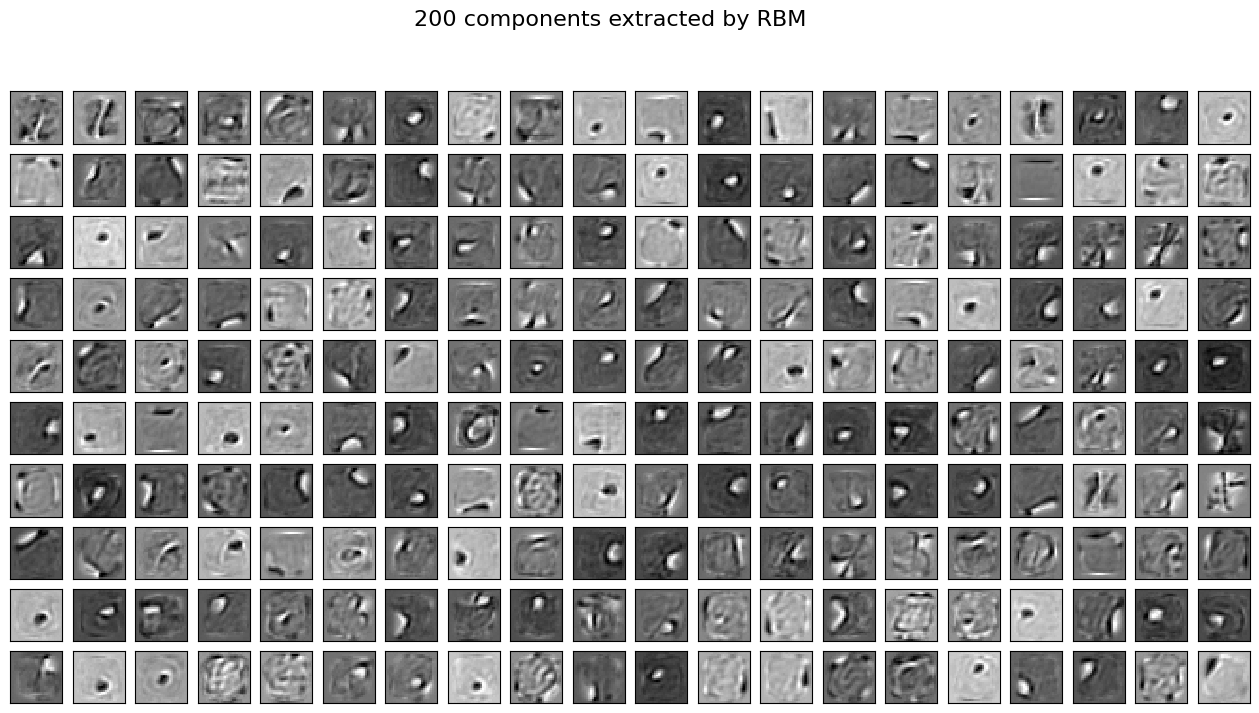

In [16]:
%matplotlib inline
weightmap_shape = (28,28)
fig,axes = plt.subplots(10,20, figsize=(16,8))
fig.suptitle('200 components extracted by RBM', fontsize=16)
fig.subplots_adjust(hspace = 0.1)
for i,ax in enumerate(axes.flatten()):

    ax.imshow(
        W[i].reshape(weightmap_shape), # From (784,) to (28, 28) in order to plot the image
        cmap=plt.cm.gray_r,
        interpolation='nearest'
    )
    ax.set_xticks([])
    ax.set_yticks([])


## Use extracted featured to train a Logistic Regression model

In [17]:
# Run logistic regression on the transformed data, i.e the latent features

logrbm = linear_model.LogisticRegression(C=1.0, verbose=1, solver='liblinear', multi_class='auto')

h = rbm.transform(trainx)
logrbm.fit(h,trainy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LibLinear]

LogisticRegression(multi_class='auto', solver='liblinear', verbose=1)

In [18]:
print(classification_report(testy, logrbm.predict(rbm.transform(testx))))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.94      0.95      1032
           3       0.94      0.95      0.94      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.98      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.93      0.95      0.94       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [19]:
rbm_biases = np.load("rbm_biases.npy")
rbm_weights = np.load("rbm_weights.npy")

print(rbm_biases.shape, rbm_weights.shape)
#testh = 1/(1 + np.exp(-(np.dot(data,rbm_weights.transpose()) + rbm_biases)))

(200,) (200, 784)


In [20]:
rbm_weight = rbm_weights.T
rbm_bias = rbm_biases

## Build a Deep Belief Net.
### This is nothing but a Multi Layer Perceptron intialised with trained RBM weights and biases
### We will use keras which already has a lot of optimizations built in for neural networks

In [22]:
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=784, name='rbm'))
model.add(Dense(10, activation='softmax'))
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Con categorical_crossentropy fallo de shape esperada None
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# set weights between input and hidden layer and hidden biases
layer = model.get_layer('rbm')
layer.set_weights([rbm_weight,rbm_bias])


# Train the model, iterating on the data in batches of 32 samples
model.fit(trainx, trainy, epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7988 - loss: 1.1639
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9640 - loss: 0.1234
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9749 - loss: 0.0831
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9808 - loss: 0.0593
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9855 - loss: 0.0432
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9886 - loss: 0.0346
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9918 - loss: 0.0247
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9941 - loss: 0.0190
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9942 - loss: 0.0157
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9967 - loss: 0.0115


In [23]:
print(classification_report(testy, np.argmax(model.predict(testx),axis=1)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.97      0.98      0.97       892
           6       0.98      0.98      0.98       958
           7       0.99      0.95      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.96      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
# Liberar recursos GPU
# descomentar si se usa GPU

# from numba import cuda
# cuda.select_device(0)
# cuda.close()